In [199]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
from videoseg.youtube_vis import register_youtube_vis_from_dicts, get_dicts, get_thing_classes
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
import detectron2.data.transforms as T
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import pycocotools.mask as mask_utils
import torch
import random
import cv2
import os
import matplotlib
import numpy as np

In [3]:
path = "/mnt/datasets/public/youtube-vis/train/train_person.json"
youtube_vis_train = MetadataCatalog.get("youtube-vis-train")
MetadataCatalog.get("youtube-vis-train").thing_classes = get_thing_classes(path)
train_dataset_dicts = get_dicts(path)

path = "/mnt/datasets/public/youtube-vis/train/train_person.json"
youtube_vis_val = MetadataCatalog.get("youtube-vis-val")
MetadataCatalog.get("youtube-vis-val").thing_classes = get_thing_classes(path)
val_dataset_dicts = get_dicts(path, eval=True)

Processing time: 00:00:04.37
Processing time: 00:00:04.77


In [4]:
print(MetadataCatalog.get("youtube-vis-train").thing_classes)

['person']


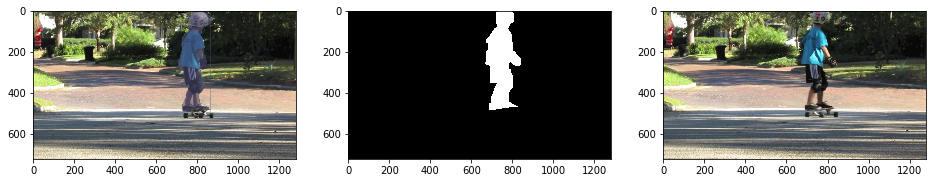

In [6]:
for d in random.sample(train_dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=youtube_vis_train, scale=1.0)
    vis = visualizer.draw_dataset_dict(d)
    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(vis.get_image())
    # get the mask from the previous frame
    tm1_np_mask = np.zeros((d["height"], d["width"]))
    for tm1_mask in d["tm1_mask"]:
        rle_mask = mask_utils.frPyObjects(tm1_mask, d["height"], d["width"])
        rle_mask = mask_utils.merge(rle_mask)
        tm1_np_mask = np.clip(tm1_np_mask + mask_utils.decode(rle_mask), 0, 1)
        
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(tm1_np_mask, cmap="gray")
    ax3 = fig.add_subplot(1, 3, 3)
    img = cv2.imread(d["tm1_file_name"])
    ax3.imshow(np.array(img[:, :, ::-1]))

**Evaluation**

In [1013]:
class DefaultVideoPredictor:
    def __init__(self, cfg):
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.model = build_model(self.cfg)
        self.model.eval()
        self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        checkpointer = DetectionCheckpointer(self.model)
        checkpointer.load(cfg.MODEL.WEIGHTS)

        self.transform_gen = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image, original_mask):
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = self.transform_gen.get_transform(original_image).apply_image(original_image)
            original_mask = Image.fromarray(original_mask)
            original_mask = original_mask.resize(image.shape[:2][::-1], 2)
            original_mask = (np.asarray(original_mask)[:, :, None] * 255).astype('uint8')
            image = np.concatenate([image, original_mask], axis=-1)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions
        
def get_video_predictor(model_config_filepath, model_weights_url):
    cfg = get_cfg()
    cfg.merge_from_file(model_config_filepath)
    # cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    cfg.MODEL.WEIGHTS = model_weights_url

    # one of cpu, cuda, mkldnn, opengl, opencl, ideep, hip, msnpu
    cfg.MODEL.DEVICE = "cuda"
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4
    predictor = DefaultVideoPredictor(cfg)
    return predictor, cfg.DATASETS.TRAIN[0]

def get_default_predictor(model_config_filepath, model_weights_url):
    cfg = get_cfg()
    cfg.merge_from_file(model_config_filepath)
    # cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    cfg.MODEL.WEIGHTS = model_weights_url

    # one of cpu, cuda, mkldnn, opengl, opencl, ideep, hip, msnpu
    cfg.MODEL.DEVICE = "cuda"

    predictor = DefaultPredictor(cfg)
    return predictor, cfg.DATASETS.TRAIN[0]

In [1001]:
predictor, meta = get_video_predictor("configs/mask_rcnn_R_50_FPN_3x.yaml", "exp_people_3x/model_final.pth")
default_predictor, default_meta = get_default_predictor("../../configs/Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml",
                                                        "https://dl.fbaipublicfiles.com/detectron2/Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv/18131413/model_0039999_e76410.pkl")

Config 'configs/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [1002]:
d = random.sample(val_dataset_dicts, 1)[0]
image = np.array(cv2.imread(d["file_name"]))
tm1_np_mask = np.zeros((d["height"], d["width"]))
for tm1_mask in d["tm1_mask"]:
    rle_mask = mask_utils.frPyObjects(tm1_mask, d["height"], d["width"])
    rle_mask = mask_utils.merge(rle_mask)
    tm1_np_mask = np.clip(tm1_np_mask + mask_utils.decode(rle_mask), 0, 1)

predictions = predictor(image, tm1_np_mask)

In [929]:
v = Visualizer(image, MetadataCatalog.get(meta), scale=1.0)
v = v.draw_instance_predictions(predictions["instances"].to("cpu"))

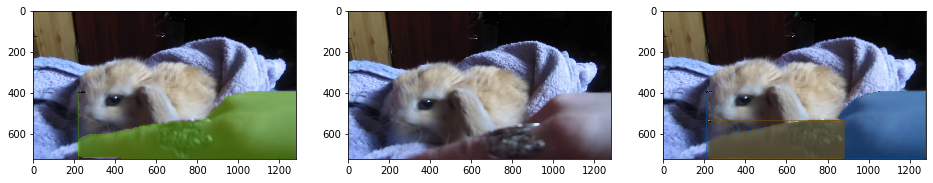

In [930]:
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=youtube_vis_train, scale=1.0)
vis = visualizer.draw_dataset_dict(d)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(vis.get_image())
ax3 = fig.add_subplot(1, 3, 2)
img = cv2.imread(d["tm1_file_name"])
ax3.imshow(np.array(img[:, :, ::-1]))

ax4 = fig.add_subplot(1, 3, 3)
ax4.imshow(v.get_image()[:, :, ::-1])

In [938]:
def compare_frame(default_predictor, video_predictor, frame, tm1_numpy_mask, seed=2021):
    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(1, 4, 1)
    ax1.set_title("original frame")
    ax1.imshow(frame[:, :, ::-1])

    ax2 = fig.add_subplot(1, 4, 2)
    default_pred = default_predictor(frame)
    v = Visualizer(frame, MetadataCatalog.get(default_meta), scale=1.0)
    person_indices = (default_pred["instances"].pred_classes == 0).nonzero().squeeze(dim=1)
    people = default_pred["instances"][person_indices]
    people.remove("pred_boxes")
    people.remove("scores")
    people.remove("pred_classes")
    np.random.seed(seed)
    v_raw = v.draw_instance_predictions(people.to("cpu"))
    ax2.set_title("pretrained model (raw)")
    ax2.imshow(v_raw.get_image()[:, :, ::-1])
    pretrained_raw = v_raw.get_image()
    
    ax3 = fig.add_subplot(1, 4, 3)
    v = Visualizer(frame, MetadataCatalog.get(default_meta), scale=1.0)
    np.random.seed(seed)
    v = v.draw_instance_predictions(people[[0]].to("cpu"))
    ax3.set_title("pretrained model (+ selection)")
    ax3.imshow(v.get_image()[:, :, ::-1])
    pretrained_post = v.get_image()
    
    ax4 = fig.add_subplot(1, 4, 4)
    video_pred = video_predictor(frame, tm1_numpy_mask)
    v = Visualizer(frame, MetadataCatalog.get(meta), scale=1.0)
    np.random.seed(seed)
    video_pred["instances"].remove("pred_boxes")
    video_pred["instances"].remove("scores")
    video_pred["instances"].remove("pred_classes")
    v = v.draw_instance_predictions(video_pred["instances"].to("cpu"))
    ax4.set_title("4-channel model (raw)")
    ax4.imshow(v.get_image()[:, :, ::-1])
    mask = video_pred["instances"].pred_masks.cpu().numpy()
    tm1_numpy_mask = mask.astype("uint8")
    new_post = v.get_image()
    
    first_row = np.concatenate([frame, pretrained_raw], axis=1)
    second_row = np.concatenate([pretrained_post, new_post], axis=1)
    
    #return np.concatenate([first_row, second_row], axis=0)

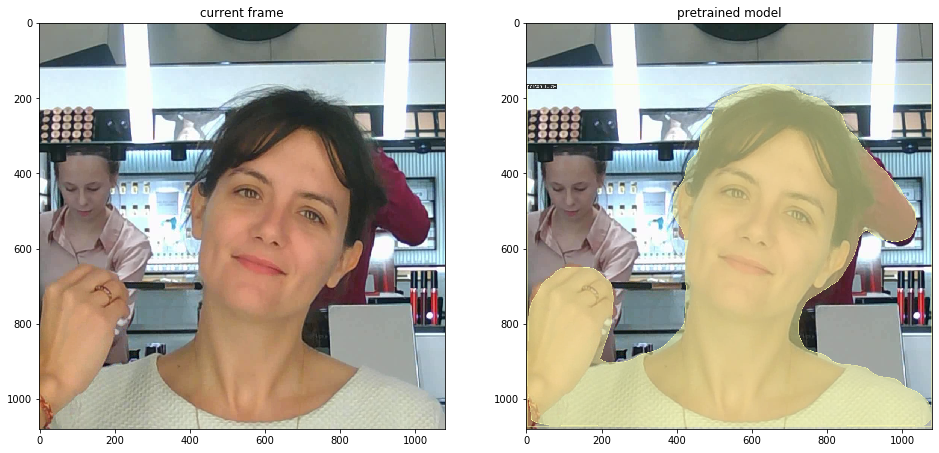

In [1007]:
video_path = "/mnt/clients/coconut_parrot/input/video14.avi"
cap, start_frame = cv2.VideoCapture(video_path), 220
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
ret, frame = cap.read()
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("current frame")
ax1.imshow(frame[:, :, ::-1])
ax2 = fig.add_subplot(1, 2, 2)
default_pred = default_predictor(frame)
v = Visualizer(frame, MetadataCatalog.get(default_meta), scale=1.0)
person_indices = (default_pred["instances"].pred_classes == 0).nonzero().squeeze(dim=1)
#index people instances only
people = default_pred["instances"][person_indices][[0]]
v = Visualizer(frame, MetadataCatalog.get(default_meta), scale=1.0)
v = v.draw_instance_predictions(people.to("cpu"))
ax2.set_title("pretrained model")
ax2.imshow(v.get_image()[:, :, ::-1])
tm1_numpy_mask = people[:1].pred_masks[0].cpu().numpy()

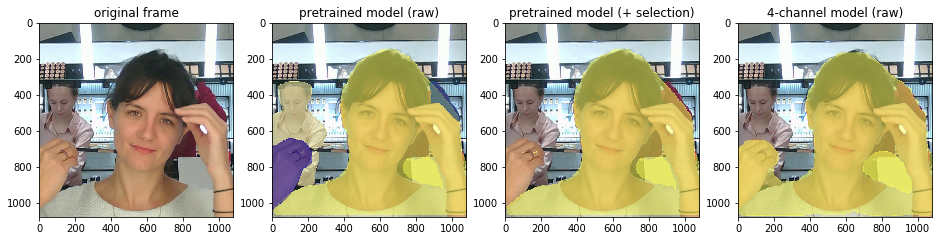

In [993]:
ret, frame = cap.read()
compare_frame(default_predictor, predictor, frame, tm1_numpy_mask, seed=2022)

In [994]:
def video_writer(dst, height, width):
    demo_video = cv2.VideoWriter(dst, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 24, (height * 2, width * 2))
    cur_frame = start_frame
    while cur_frame < start_frame + 80:
        _, frame = cap.read()
        processed_frame = compare_frame(default_predictor, predictor, frame, tm1_numpy_mask, seed=2022)
        demo_video.write(processed_frame)
        cur_frame += 1
    demo_video.release()
    # cv2.destroyAllWindows()

In [921]:
video_writer('./test.mp4', 1080, 1080)